In [2]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
import sklearn

In [3]:
df_2018 = pd.read_csv('2018_public_use_data.csv')
print(df_2018.shape)

(6436, 1181)


In [4]:
df_filled = df_2018.copy()

In [5]:
df_filled.sample(5)

,PUBID,REGION,CENDIV,PBA,SQFT,SQFTC,WLCNS,RFCNS,RFCOOL,RFTILT,...,ZLTEXPC,ZPKLT,ZPKLTINOUT,ZPKLTN,ZWINTYP,ZTINT,ZREFL,ZAWN,ZSKYLT,ZDAYLTP
4987,4988,2,4,5,1800000,10,5,5,1,2,...,1,1,1,1,1,1,1,1,1,1
6265,6266,1,2,16,260000,8,6,6,2,1,...,0,0,0,0,0,0,0,0,0,0
2746,2747,3,7,8,58000,6,1,2,2,2,...,0,0,0,0,0,0,0,0,0,0
5584,5585,2,3,14,335000,8,1,8,2,1,...,0,0,0,0,0,0,0,0,0,0
5740,5741,2,3,26,10500,4,3,5,2,2,...,0,0,0,0,0,0,0,0,0,0


In [6]:
df_codebook = pd.read_csv('2018cbecs_codebook_wDicts.csv')
df_codebook.head()

,category,file_order,col_name,col_type,length,col_description,codes,codes_dict
0,0,1,PUBID,Char,5,Public use file building identifier,00001 - 06436,{'00001 - 06436': 'continuous numerical range'}
1,0,2,REGION,Char,1,Census Region,1=Northeast\n2=Midwest\n3=South\n4=West,"{'1': 'Northeast', '2': 'Midwest', '3': 'South..."
2,0,3,CENDIV,Char,1,Census division,1=New England\n2=Middle Atlantic \n3=East Nor...,"{'1': 'New England', '2': 'Middle Atlantic', '..."
3,0,4,PBA,Num,8,Principal building activity,1=Vacant\n2=Office\n4=Laboratory\n5=Nonrefrige...,"{'1': 'Vacant', '2': 'Office', '4': 'Laborator..."
4,1,5,SQFT,Num,8,Square footage,"1,001 - 2,100,000","{'1,001 - 2,100,000': 'continuous numerical ra..."


In [7]:
print(df_codebook.category.unique())

[0 1 2 3 4 5 6 7]


In [8]:
df_codebook_2012 = pd.read_csv('2012cbecs_codebook_wDicts.csv')
df_codebook_2012.head()

,category,file_order,col_name,col_type,length,format,col_description,codes,codes_dict
0,0,1.0,PUBID,Char,5.0,NaN,Building identifier,00001 - 06720,{'00001 - 06720': 'continuous numerical range'}
1,0,2.0,REGION,Char,1.0,$REGION.,Census region,'1' = 'Northeast'\r\n'2' = 'Midwest'\r\n'3' = ...,"{'1': 'Northeast', '2': 'Midwest', '3': 'South..."
2,0,3.0,CENDIV,Char,1.0,$CENDIV.,Census division,'1' = 'New England'\r\n'2' = 'Middle Atlantic'...,"{'1': 'New England', '2': 'Middle Atlantic', '..."
3,0,4.0,PBA,Char,2.0,$PBA.,Principal building activity,'01' = 'Vacant'\r\n'02' = 'Office'\r\n'04' = '...,"{'01': 'Vacant', '02': 'Office', '04': 'Labora..."
4,1,5.0,FREESTN,Char,1.0,$YES.,Freestanding building,1' = 'Yes'\r\nMissing='No',"{'1': 'Yes', 'Missing': 'No'}"


In [9]:
col_name_2012 = df_codebook_2012.col_name.values.tolist()
col_name_2018 = df_codebook.col_name.values.tolist()

In [10]:
keep_var = df_codebook[df_codebook['col_name'].isin(col_name_2012)]
keep_var.shape

## 330 overlapping variables 

(330, 8)

In [11]:
keep_var_list = keep_var.col_name.values.tolist()

In [12]:
## Read 2012 Data

df_2012 = pd.read_csv('2012cbecs_train-data.csv')
df_2012_cons = pd.read_csv('2012cbecs_consumption-data.csv')

In [13]:
df_2012.sample(5)

,PUBID,REGION,CENDIV,PBA,SQFT,NFLOOR,BASEMNT,FLCEILHT,NELVTR,NESLTR,...,TRIM,PLGCTRL,DRLGHT,LTEXPC,PKLT,WINTYP,TINT,REFL,AWN,SKYLT
3637,3638,1,1,13,13000,3,1.0,8,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,2,0.0,0.0,0.0,0.0
1542,1543,2,3,12,3600,1,0.0,12,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,2,0.0,0.0,0.0,0.0
537,538,2,3,5,1800,1,0.0,8,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4,0.0,0.0,0.0,0.0
5931,5932,3,5,26,32000,2,0.0,24,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,1,1.0,0.0,1.0,0.0
6675,6676,2,4,6,8000,1,0.0,12,0.0,0.0,...,0.0,0.0,0.0,4.0,1.0,2,1.0,0.0,1.0,0.0


In [14]:
df_2012 = df_2012[df_2012.columns.intersection(keep_var_list)]
df_2012.shape

(6720, 330)

In [15]:
df_2012_cons.sample(5)

,HDD65,CDD65,MFHTBTU,MFCLBTU,MFVNBTU,MFWTBTU,MFLTBTU,MFCKBTU,MFRFBTU,MFOFBTU,...,MFUSED,DHUSED,DHHT1,DHHT2,DHCOOL,DHCOOK,DHWATR,DHMANU,DHOTH,PUBCLIM
4522,5145,1132,5509066.0,1219026.0,969699.0,612477.0,822953.0,269435.0,515558.0,154480.0,...,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
958,6218,946,41297116.0,10152765.0,20367921.0,15273147.0,13053867.0,4273529.0,1891409.0,4451203.0,...,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
107,4085,1005,13781921.0,547358.0,3197154.0,29202.0,2664936.0,1232834.0,129838.0,133645.0,...,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4633,3036,2052,11347.0,20734.0,836.0,577.0,4398.0,0.0,0.0,0.0,...,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
5782,2418,1666,19233.0,118335.0,43126.0,906.0,76612.0,0.0,0.0,4117.0,...,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


In [16]:
category_map = {}
for cat in df_codebook.category.unique():
    category_cols_df = df_codebook[df_codebook['category'] == cat]
    cat_cols = []
    for col in category_cols_df.col_name.values:
        if type(col) == str:
            cat_cols.append(col)
    category_map[cat] = cat_cols

In [17]:
keep_cols = []
for wanted_cols in category_map.values():
    for col in wanted_cols:
        keep_cols.append(col)
print(len(keep_cols))

561


In [18]:
def find_num_cat_cols(list_of_dfs, category_num, list_of_numcols, list_of_catcols):
    numeric_cols = []
    categorical_cols = []
    for col in list_of_dfs[category_num].columns:
        if col in list_of_numcols:
            numeric_cols.append(col)
        elif col in list_of_catcols:
            categorical_cols.append(col)
    df_category = list_of_dfs[category_num].copy()[numeric_cols + categorical_cols]
    return df_category, numeric_cols, categorical_cols

In [19]:
def create_new_codebook(codebook, cols):
    new_codebook = dict(codebook.set_index('col_name').loc[cols].codes_dict)
    return new_codebook

In [20]:
def create_replace_map(new_codebook, category_df, return_errors=False):
    replace_map = {}
    error_map = {}
    for col_name, codebook in new_codebook.items():
        try:
            codebook = json.loads(codebook.replace("'", '"'))
        except ValueError as e:
            print(f'JSONDecodeError on column {col_name}')
            error_map[col_name] = (col_name, e)
            codebook = codebook.replace('"', '')
            codebook = json.loads(codebook.replace("'", '"'))
        finally:
            if col_name in category_df.columns:
                for code, code_val in codebook.items():
                    if code == '2' and code_val == 'No':
                        replace_map[col_name] = 2
    
    if return_errors == True:
        return replace_map, error_map
    else:
        return replace_map

In [21]:
def build_hist(column_list):
    figname = 0
    for column in column_list:
        plt.figure(figname)
        sns.set(rc = {'figure.figsize':(2,2)})
        sns.histplot(data=df, x=column, kde=True)
        figname += 1

In [22]:
df_filled = df_filled[keep_cols]
print(df_filled.shape)
df_filled.sample(5)

(6436, 561)


,PUBID,REGION,CENDIV,PBA,SQFT,SQFTC,WLCNS,RFCNS,RFCOOL,RFTILT,...,LTEXPC,PKLT,PKLTINOUT,PKLTN,WINTYP,TINT,REFL,AWN,SKYLT,DAYLTP
5231,5232,4,9,15,1850,2,1,6,1,1,...,4,1,2,20,2,2,2,1,2,0
301,302,4,9,13,16000,4,3,4,2,1,...,1,2,.,5,2,1,2,2,2,0
1838,1839,2,4,2,460000,8,2,6,2,1,...,1,2,.,5,2,1,2,2,2,5
4540,4541,3,5,13,330000,8,6,6,1,1,...,1,2,.,5,2,2,2,1,1,40
5319,5320,3,5,25,3000,2,4,3,2,2,...,4,1,2,10,1,1,2,1,2,20


In [23]:
category_dfs = {}
for cat_name, cat_list in category_map.items():
    category_dfs[cat_name] = df_filled[cat_list]
category_dfs[0].sample(10)

,PUBID,REGION,CENDIV,PBA
4070,4071,4,8,2
4803,4804,2,3,2
1162,1163,1,2,14
5401,5402,3,5,16
5178,5179,3,5,2
2713,2714,3,5,5
5307,5308,2,3,5
6200,6201,1,2,2
6433,6434,3,5,2
959,960,1,2,2


In [24]:
codebook_check = df_codebook.copy().set_index('col_name')
num_cols = []
cat_cols = []
for col in codebook_check.index:
    if codebook_check.loc[col].col_type == 'Num':
        num_cols.append(col)
    else:
        cat_cols.append(col)
print(len(num_cols))
print(len(cat_cols))

558
3


In [25]:
df_filled = df_filled[df_filled.columns.intersection(keep_var_list)]
df_filled.shape

(6436, 330)

In [26]:
df_filled.sample(5)

,PUBID,REGION,CENDIV,PBA,SQFT,SQFTC,WLCNS,RFCNS,RFCOOL,RFTILT,...,PLGCTRL,DRLGHT,LTEXPC,PKLT,WINTYP,TINT,REFL,AWN,SKYLT,DAYLTP
3803,3804,3,6,26,260000,8,5,1,2,2,...,2,2,3,1,3,1,2,2,2,30
3254,3255,2,3,25,35000,5,1,2,2,2,...,2,2,1,1,2,2,2,1,2,35
6122,6123,3,5,7,1700000,10,3,1,2,1,...,1,2,2,1,3,1,1,2,1,10
978,979,3,5,12,8000,3,3,4,2,2,...,2,1,1,1,2,2,2,2,2,10
1477,1478,2,4,14,132000,7,1,1,1,1,...,2,2,4,1,3,1,1,1,1,25


In [27]:
df_codebook = create_new_codebook(df_codebook, list(df_filled.columns))
replace_map, error_map = create_replace_map(df_codebook, df_filled, return_errors=True)
print(error_map)

JSONDecodeError on column BLDSHP
JSONDecodeError on column WTHTEQ
{'BLDSHP': ('BLDSHP', JSONDecodeError("Expecting ',' delimiter: line 1 column 127 (char 126)")), 'WTHTEQ': ('WTHTEQ', JSONDecodeError("Expecting ',' delimiter: line 1 column 43 (char 42)"))}


In [28]:
df_filled = df_filled.replace(to_replace=replace_map, value=0).fillna(value=0)
df_filled = df_filled.replace(to_replace='.', value=0)
df_filled[0:20]

,PUBID,REGION,CENDIV,PBA,SQFT,SQFTC,WLCNS,RFCNS,RFCOOL,RFTILT,...,PLGCTRL,DRLGHT,LTEXPC,PKLT,WINTYP,TINT,REFL,AWN,SKYLT,DAYLTP
0,1,3,5,2,210000,8,1,4,0,1,...,2,2,2,1,2,2,2,2,1,0
1,2,4,9,2,28000,5,1,6,1,1,...,2,2,1,1,1,1,1,2,1,15
2,3,3,5,8,2100,2,1,4,0,3,...,2,2,4,1,2,2,2,1,2,40
3,4,3,7,5,240000,8,2,6,1,1,...,2,2,2,1,2,1,2,2,2,5
4,5,1,2,5,295000,8,3,6,0,1,...,2,2,4,1,2,1,2,2,1,0
5,6,3,5,14,94000,6,1,6,1,1,...,2,2,4,1,2,2,2,2,2,20
6,7,4,8,14,41000,5,1,4,1,1,...,2,2,1,1,2,1,2,2,2,75
7,8,2,3,5,122000,7,1,6,1,1,...,1,2,4,1,3,2,2,1,2,0
8,9,4,8,25,96000,6,3,6,1,1,...,2,2,3,1,1,1,2,2,2,40
9,10,1,2,14,220000,8,1,1,0,1,...,2,2,4,1,2,1,2,1,2,10


In [29]:
objects = list(df_filled.select_dtypes(['object']).columns)
objects

['BASEMNT',
 'ELEVTR',
 'NELVTR',
 'ESCLTR',
 'NESLTR',
 'RENOV',
 'RENCOS',
 'RENADD',
 'RENRDC',
 'RENINT',
 'RENRFF',
 'RENWIN',
 'RENHVC',
 'RENLGT',
 'RENPLB',
 'RENELC',
 'RENINS',
 'RENSAF',
 'RENSTR',
 'RENOTH',
 'DRYCL',
 'VACANT',
 'RWSEAT',
 'PBSEAT',
 'EDSEAT',
 'FDSEAT',
 'HCBED',
 'NRSBED',
 'LODGRM',
 'COURT',
 'FEDFAC',
 'FACACT',
 'MANIND',
 'PLANT',
 'FACDST',
 'FACDHW',
 'FACDCW',
 'FACELC',
 'BLDPLT',
 'GOVTYP',
 'OWNOCC',
 'OWNPPR',
 'NWNPPR',
 'NWNOPR',
 'WHOPPR',
 'OCCUPYP',
 'LODOCCP',
 'FKTYPE',
 'HEATP',
 'HTLS50',
 'PKGHT',
 'FURNAC',
 'SLFCON',
 'BOILER',
 'HTPMPH',
 'STHW',
 'OTHTEQ',
 'BLRAIR',
 'BLRDUCT',
 'BLRFNCL',
 'BLRRAD',
 'HPHAIR',
 'HPHGRD',
 'HPHDUAL',
 'HPHWTR',
 'HPHVRF',
 'MAINHT',
 'NWMNHT',
 'COOLP',
 'RCAC',
 'PKGCL',
 'CHILLR',
 'HTPMPC',
 'ACWNWL',
 'EVAPCL',
 'OTCLEQ',
 'CHWT',
 'HPCAIR',
 'HPCGRD',
 'HPCDUAL',
 'HPCWTR',
 'CHLAIR',
 'CHLFNCL',
 'CHLBEAM',
 'CHLAIRCL',
 'CHLWTRCL',
 'CHLABSRP',
 'MAINCL',
 'NWMNCL',
 'EMCS',
 'EMCSLT',
 

In [30]:
for col in objects:
    df_filled[col] = df_filled[col].astype(str).astype(int)

In [31]:
list(df_filled.select_dtypes(['object']).columns)

[]

In [32]:
print(df_filled.NFLOOR.dtype)
print(df_filled.BASEMNT.dtype)
print(df_filled.FLCEILHT.dtype)
print(df_filled.NELVTR.dtype)
print(df_filled.NESLTR.dtype)
print(df_filled.RWSEAT.dtype)
print(df_filled.PBSEAT.dtype)
print(df_filled.HCBED.dtype)
print(df_filled.NRSBED.dtype)
print(df_filled.LODGRM.dtype)
print(df_filled.NOCC.dtype) 
print(df_filled.NOCCAT.dtype)
print(df_filled.XRAYN.dtype)
print(df_filled.TVVIDEON.dtype)
print(df_filled.RFGCOMPN.dtype)
print(df_filled.RFGRSN.dtype)
print(df_filled.SERVERN.dtype)
print(df_filled.RFGCOMP.dtype)

int64
int32
int64
int32
int32
int32
int32
int32
int32
int32
int64
int64
int32
int32
int32
int32
int32
int32


In [33]:
## Adjusting for weird values

df_filled.NFLOOR.replace(to_replace=994, value=10, inplace=True)
df_filled.NFLOOR.replace(to_replace=995, value=15, inplace=True)
df_filled.BASEMNT.replace(to_replace=995, value=5, inplace=True)
df_filled.FLCEILHT.replace(to_replace=995, value=51, inplace=True)
df_filled.NELVTR.replace(to_replace=995, value=31, inplace=True)
df_filled.NESLTR.replace(to_replace=995, value=11, inplace=True)
df_filled.RWSEAT.replace(to_replace=99995, value=2001, inplace=True)
df_filled.PBSEAT.replace(to_replace=999995, value=15001, inplace=True)
df_filled.HCBED.replace(to_replace=9995, value=251, inplace=True)
df_filled.NRSBED.replace(to_replace=9995, value=251, inplace=True)
df_filled.LODGRM.replace(to_replace=99995, value=1001, inplace=True)
df_filled.NOCC.replace(to_replace=996, value=0, inplace=True) 
df_filled.NOCCAT.replace (to_replace=996, value=0, inplace=True) 
df_filled.XRAYN.replace(to_replace=995, value=21, inplace=True)
df_filled.TVVIDEON.replace(to_replace=995, value=201, inplace=True) 
df_filled.RFGCOMPN.replace(to_replace=9995, value=1001, inplace=True)
df_filled.RFGRSN.replace(to_replace=99995, value=1001, inplace=True)
df_filled.SERVERN.replace(to_replace=9995, value=501, inplace=True)
df_filled.RFGCOMP.replace(to_replace=99995, value=0, inplace=True)

Training Target 

In [34]:
col_list = ['MFHTBTU',
'MFCLBTU',
'MFVNBTU',
'MFWTBTU',
'MFLTBTU',
'MFCKBTU',
'MFRFBTU',
'MFOFBTU',
'MFPCBTU',
'MFOTBTU',
'ELHTBTU',
'ELCLBTU',
'ELVNBTU',
'ELWTBTU',
'ELLTBTU',
'ELCKBTU',
'ELRFBTU',
'ELOFBTU',
'ELPCBTU',
'ELOTBTU',
'NGHTBTU',
'NGCLBTU',
'NGWTBTU',
'NGCKBTU',
'NGOTBTU',
'FKHTBTU',
'FKCLBTU',
'FKWTBTU',
'FKCKBTU',
'FKOTBTU',
'DHHTBTU',
'DHCLBTU',
'DHWTBTU',
'DHCKBTU',
'DHOTBTU']
y_train = pd.DataFrame(columns=["energy_consumption"])
y_train["energy_consumption"]=(df_2012_cons[col_list].sum(axis=1))
y_train.sample(5)

,energy_consumption
1186,1459594.0
5848,1710380.0
39,18559718.0
5850,193362.0
6070,550936.0


In [35]:
y_train.describe()

,energy_consumption
count,6.720000e+03
mean,3.406891e+07
std,1.212115e+08
min,0.000000e+00
25%,4.779055e+05
50%,2.513947e+06
75%,1.606980e+07
max,2.963733e+09


In [36]:
train_total = df_2012.join(y_train)
train_total.shape

(6720, 331)

In [37]:
train_total = train_total[train_total.energy_consumption != 0]
train_total.shape

(6554, 331)

In [38]:
X_train1 = train_total.drop(columns=['energy_consumption'])
y_train = pd.DataFrame(train_total['energy_consumption'])

In [39]:
X_train1.shape

(6554, 330)

In [40]:
y_train.shape

(6554, 1)

In [41]:
X_test = df_filled.copy()

# PCA

In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

lr = LinearRegression()
scaler_train = StandardScaler()
pca_train = PCA()

X_train = X_train1.to_numpy(dtype=float, copy=True)
X_train_scaled = scaler_train.fit_transform(X_train)
X_train_pca = pca_train.fit_transform(X_train_scaled)

In [43]:
pca_exp_var = pd.DataFrame(pca_train.explained_variance_ratio_,)
pca_exp_var.T

,0,1,2,3,4,5,6,7,8,9,...,320,321,322,323,324,325,326,327,328,329
0,0.104419,0.030132,0.023229,0.021101,0.018969,0.017866,0.016023,0.015817,0.014971,0.013387,...,5.345760e-34,5.345760e-34,5.345760e-34,5.345760e-34,5.345760e-34,5.345760e-34,5.345760e-34,5.345760e-34,5.345760e-34,2.376989e-34


In [44]:
# plt.figure(figsize=(5,5))
# plt.plot(np.cumsum(pca_train.explained_variance_ratio_))
# plt.xlabel('num components')
# plt.ylabel('cumulative explained variance')

<AxesSubplot:xlabel='0', ylabel='1'>

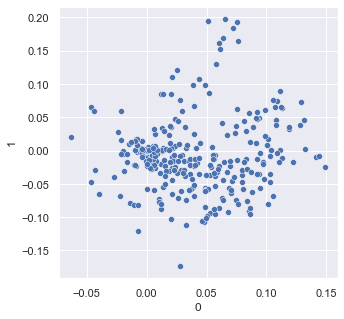

In [45]:
pca_train_df = pd.DataFrame(pca_train.components_)
sns.set(rc = {'figure.figsize':(5,5)})
sns.scatterplot(x=pca_train_df.T[0], y=pca_train_df.T[1])

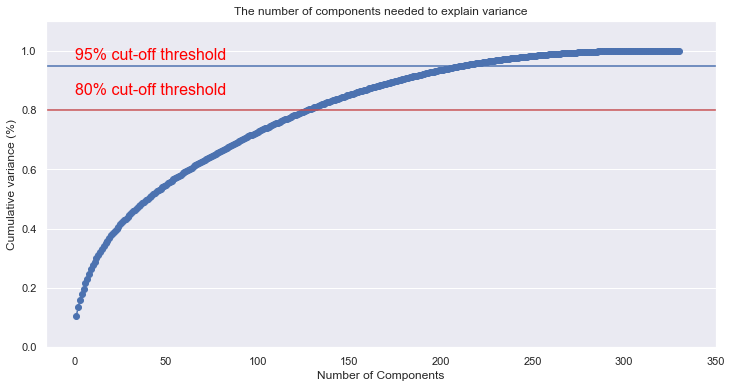

In [46]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 331, step=1)
y = np.cumsum(pca_train.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 400, step=50)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.80, color='r', linestyle='-')
plt.text(0.5, 0.85, '80% cut-off threshold', color = 'red', fontsize=16)

plt.axhline(y=0.95, color='b', linestyle='-')
plt.text(0.5, 0.97, '95% cut-off threshold', color = 'red', fontsize=16)


ax.grid(axis='x')
plt.show()

# https://www.kaggle.com/code/kushal1506/deciding-n-components-in-pca/notebook

In [47]:
pca_final = PCA(n_components = 200) # INSERT NUMBER OF COMPONENTS
X_train_pca = pca_final.fit_transform(X_train_scaled)

In [48]:
X_train_pca.shape

(6554, 200)

In [49]:
# pca_exp_var = pd.DataFrame(pca_final.explained_variance_ratio_,)
# pca_exp_var.T

In [50]:
## PCA on 2018 data

X_test = X_test.to_numpy(dtype=float, copy=True)
X_test_scaled = scaler_train.transform(X_test)
X_test_pca = pca_final.transform(X_test_scaled)
X_test_pca.shape

(6436, 200)

SVM

In [51]:
y_train_final = np.log(y_train).to_numpy().ravel()
y_train_final

array([10.89429189, 16.28185805, 11.26171675, ..., 13.77515096,
       14.83377215, 16.40779144])

In [52]:
from sklearn import svm
regr = svm.SVR(kernel='linear')
model_svm = regr.fit(X_train_pca, y_train_final)

In [53]:
y_pred = model_svm.predict(X_test_pca)
y_pred.shape

(6436,)

In [54]:
predicted = pd.DataFrame(y_pred).rename(columns={0:'predicted'})
predicted.describe()

,predicted
count,6436.000000
mean,7.693567
std,120.047268
min,-1517.416391
25%,2.736754
50%,13.498734
75%,20.792255
max,1376.187517


In [55]:
# predicted[predicted['predicted'] >= 500].shape
# predicted[predicted['predicted'] <= -0].shape
# df_outliers.to_csv('df_outliers.csv')

Testing with Residuals

In [56]:
testing = model_svm.predict(X_train_pca)
testing = pd.DataFrame(testing)
testing

,0
0,11.608877
1,16.370110
2,11.902541
3,18.999241
4,16.675391
...,...
6549,16.828631
6550,11.435836
6551,12.814030
6552,14.487453


In [57]:
y_train_final = pd.DataFrame(y_train_final).rename(columns={0:'energy_consumption'})
df1=pd.concat([y_train_final,testing],axis=1,join='inner').rename(columns={'energy_consumption': 'original', 0:'predicted'})
df1

,original,predicted
0,10.894292,11.608877
1,16.281858,16.370110
2,11.261717,11.902541
3,18.388926,18.999241
4,15.159338,16.675391
...,...,...
6549,16.526452,16.828631
6550,8.839277,11.435836
6551,13.775151,12.814030
6552,14.833772,14.487453


In [58]:
df1['residual']= df1['original'] - df1['predicted']
df1

,original,predicted,residual
0,10.894292,11.608877,-0.714586
1,16.281858,16.370110,-0.088252
2,11.261717,11.902541,-0.640825
3,18.388926,18.999241,-0.610315
4,15.159338,16.675391,-1.516053
...,...,...,...
6549,16.526452,16.828631,-0.302179
6550,8.839277,11.435836,-2.596559
6551,13.775151,12.814030,0.961121
6552,14.833772,14.487453,0.346319


<AxesSubplot:xlabel='predicted', ylabel='residual'>

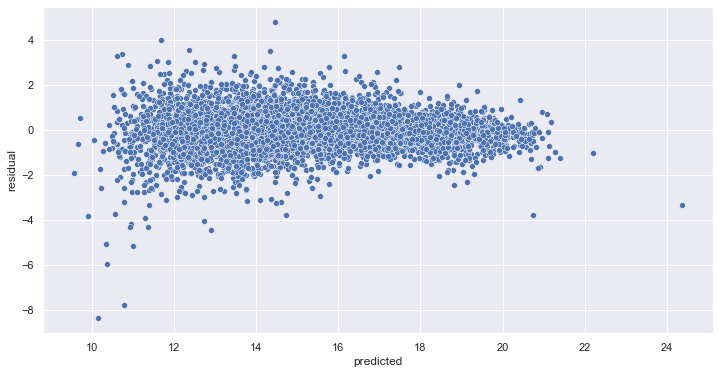

In [59]:
sns.scatterplot(data=df1, x="predicted", y="residual")

In [69]:
model_svm.score(X_train_pca, y_train_final)

0.876878101540534

Rerunning SVM without outliers

In [70]:
# df_outliers=pd.concat([df_filled,predicted],axis=1,join='inner')
# X_test2 = df_outliers.drop(df_outliers[df_outliers.predicted <= -500].index)
# X_test_final = X_test2.drop(X_test2[X_test2.predicted >= 500].index)

In [71]:
# X_test2.shape

In [72]:
# X_test_final.shape

In [73]:
# X_test_final = pd.DataFrame(X_test_final)
# X_test_final

In [74]:
# X_test_final.drop(columns=['predicted'], axis=1, inplace=True)

In [75]:
# X_test_final = X_test_final.to_numpy(dtype=float, copy=True)
# X_test_scaled_final = scaler_train.transform(X_test_final)
# X_test_pca_final = pca_final.transform(X_test_scaled_final)

In [76]:
# y_pred_final = model_svm.predict(X_test_pca_final)
# y_pred_final.shape

In [77]:
# predicted_final = pd.DataFrame(y_pred_final).rename(columns={0:'predicted'})

In [78]:
# predicted_final.describe()

Write to CSV

In [81]:
df_2018_final=pd.concat([df_filled,predicted],axis=1,join='inner')
df_2018_final.shape

In [83]:
df_2018.to_csv('df_2018_predictions.csv')

In [86]:
train_total.to_csv('df_2012_for-train.csv')